In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Loading the configuration file, which contains information about the simulated images, and the telescopes they were modelled on, and some model hyperparameters

In [2]:
with open('../config.json') as config_file:
    config = json.load(config_file)

In [3]:
EPOCHS = 200
LR = 1e-5 
IN_SHAPE = config["image_shape_2"] # image dimensions in pixels (assuming square image)
MAGNIFICATION = config["magnification"] # magnitude of each magnification
N_MAG = config["n_magnification"] # number of magnifications required to be performed
DELTA = config["resolution_3"] # LR image resolution
alpha_t_scaling = config["alpha_t_scaling_2"] # scaling coefficient of the tangential component of the deflection angle 
VDL_WEIGHT = 0.5 # initial vdl weight
OUT_SHAPE = IN_SHAPE*MAGNIFICATION*N_MAG

### Scaling the deflection angle obtained from the SISR models:
The deflection angle values are obtained by design as $\alpha(x,y) \in (0,1)$. They are thus rescaled within appropriate bounds before their use for the purpose of lensing. The coefficients 1 and 2 correspond to the radial $\alpha_r(x,y)$ and tangential $\alpha_t(x,y)$ components of the deflection angle. While $\alpha_r(x,y)$ can ideally be used to contain all the pertaining information, this is no longer required ot be true, as the image space is discretized to pixels. To account for potential inaccuracies brought by this discretization, a (smaller) $\alpha_t(x,y)$ is used for the purpose of potential correction.

In [ ]:
alpha_bounds = [config["alpha_l"],config["alpha_h"]] # bounds for the deflection angle, used in it's scaling

alpha_coeff_1 = torch.tensor(alpha_bounds[1]-alpha_bounds[0]).repeat((OUT_SHAPE)**2).view(1,1,OUT_SHAPE,OUT_SHAPE)
alpha_coeff_2 = torch.tensor((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling).repeat((OUT_SHAPE)**2).view(1,1,OUT_SHAPE,OUT_SHAPE)

alpha_disp_1 = torch.tensor(alpha_bounds[0]).repeat((OUT_SHAPE)**2).view(1,1,OUT_SHAPE,OUT_SHAPE)
alpha_disp_2 = torch.tensor(-((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling)/2).repeat((OUT_SHAPE)**2).view(1,1,OUT_SHAPE,OUT_SHAPE)

def alpha_scaling(alpha):
    """
    Scales the deflection angle obtained from the model to meaningful bounds
    
    :param alpha: Deflection angle to be scaled
    :return: Scaled deflection angle
    """
    alpha = alpha * alpha_coeff_1.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp_1.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

def alpha_delta_scaling(alpha):
    """
    Scales the deflection angle obtained from the model to meaningful bounds
    
    :param alpha: Deflection angle to be scaled
    :return: Scaled deflection angle
    """
    alpha = alpha * alpha_coeff_2.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp_2.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

### Loading the datasets, the dataloaders and performing the required train:validation partitions
A batch size of 5 (merely for computational convenience) is used 5000 images for training, which is divided by an 80:20 validation split. The 5000 images are derived more-or-less equally from the three DM sub-structure classes. There are no high-resolution images loaded as they are not needed !

In [4]:
# We can now load the datasets, combine and shuffle them to have a (close to) homogenous distribution of all sub-structures.
BATCH_SIZE = 5 # Feel free to increase this number; all the training was done on my personal machine, hence, this limitation/

dataset_no_sub = data.LensingDataset('../Simulations/data_model_3/',['no_sub'],5000)
train_dataset_no_sub, val_dataset_no_sub = torch.utils.data.random_split(dataset_no_sub, [0.8, 0.2])

dataset_axion = data.LensingDataset('../Simulations/data_model_3/',['axion'],5000)
train_dataset_axion, val_dataset_axion = torch.utils.data.random_split(dataset_axion, [0.8, 0.2])

dataset_cdm = data.LensingDataset('../Simulations/data_model_3/',['cdm'],5000)
train_dataset_cdm, val_dataset_cdm = torch.utils.data.random_split(dataset_cdm, [0.8, 0.2])

train_dataset = torch.utils.data.ConcatDataset([train_dataset_no_sub, train_dataset_axion, train_dataset_cdm])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_no_sub, val_dataset_axion, val_dataset_cdm])

train_dataset, train_rest = torch.utils.data.random_split(train_dataset, [0.34, 0.66])
val_dataset, val_rest = torch.utils.data.random_split(val_dataset, [0.34, 0.66])

train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

# This configuration will load 5000 (low-resolution) images in total, with a 80:20 validation split. 

### Models and physics-inspired loss function loading

In [5]:
# We construct and load the SISR models to the GPU (if available). A loss module is also loaded that performs all the operations required during training.

alpha_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["alpha_depth"], in_channels=1, out_channels=1, latent_channel_count=config["latent_channels"]).to(device)
lens_loss = models.SersicProfiler(resolution=DELTA, device=device, sersic_args = [1, 1, 0.25], vdl_weight=VDL_WEIGHT)
alpha_delta_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["alpha_depth"], in_channels=1, out_channels=1, latent_channel_count=config["latent_channels"]).to(device)
classifier = models.Classifier(in_shape=OUT_SHAPE, out_classes=3, model=2, in_channels=1).to(device)
classifier_criterion = torch.nn.CrossEntropyLoss()

opt = torch.optim.Adam(params=alpha_model.parameters(),lr=LR)
opt_classifier = torch.optim.Adam(params=list(classifier.parameters())+list(alpha_delta_model.parameters()),lr=LR)

alpha_params = sum(p.numel() for p in alpha_model.parameters())
print(f"Image network parameters: {alpha_params}x2")

classifier_params = sum(p.numel() for p in classifier.parameters())
print(f"Classifier network parameters: {classifier_params}")

Image network parameters: 899843x2
Classifier network parameters: 736475


### Performing weight initialization
Several studies have shown that model weight initialization can help in more effective convergence.

In [6]:
# Performing He initialization of the model weights.

def init_weights(m):
    """
    Iterates through all the convolution and fully connected layers of the model to initialize all their weights

    :param m: Model to be initialized
    """
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)  # He initialization
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

alpha_model.apply(init_weights)

SISR(
  (residual_layer_list): ModuleList(
    (0-2): 3 x Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (subpixel_layer_list): ModuleList(
    (0): Sequential(
      (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PixelShuffle(upscale_factor=2)
      (2): ReLU()
    )
  )
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv3): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2

In [7]:
classifier.apply(init_weights)

Classifier(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (b1): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (b2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv3): Conv2d(16, 24, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (b3): Sequential(
    (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv4): Conv2d(24, 32, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (b4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), 

### Defining functions that sample the model's performance

In [8]:
def give_random_image(dataset, alpha_model, length, i=None, plot=True):
    """
    Provides a random image for evaluation

    :param dataset: Dataset used
    :param alpha_model: Model used
    :param length: Length of dataset used
    :param i: Index of the selected image, default: 
    :param plot: If true, also plots the source fitting graphs
    :return: original LR image, SR image, reconstructed source
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i][0].view(1,1,IN_SHAPE,IN_SHAPE).float()
    alpha_r = alpha_model(LR.to(device))
    alpha_r = alpha_scaling(alpha_r)
    alpha_delta = alpha_delta_model(LR.to(device))
    alpha_delta = alpha_delta_scaling(alpha_delta)
    sersic_profile, LR, source_profile = lens_loss.get_sample((alpha_r+alpha_delta).to(device), LR.to(device), plot)
    LR_im = Image.fromarray(LR.cpu().detach().numpy()[0]*255)
    sersic_im = Image.fromarray(sersic_profile.cpu().detach().numpy()[0]*255)
    source_im = Image.fromarray(source_profile.cpu().detach().numpy()[0]*255)
    return (LR_im, sersic_im, source_im)

def show_random_image(image_tuple):
    """
    Displays the images provided by the give_random_image function
    
    :param image_tuple: Tuple of images returned by the give_random_image function
    """
    LR_im, sersic_im, source_im = image_tuple[0], image_tuple[1], image_tuple[2]
    plot, axes = plt.subplots(1,3)
    plot.set_size_inches(18,6)
    axes[0].imshow(LR_im)
    axes[1].imshow(sersic_im)
    axes[2].imshow(source_im)
    axes[0].set_title("LR_interpolated")
    axes[1].set_title("Image")
    axes[2].set_title("Source Profile")

/home/ashankar/Documents/Work/.env/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


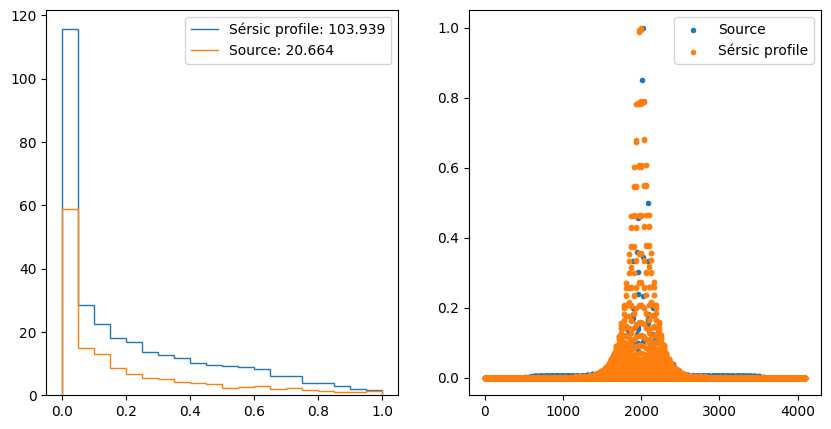

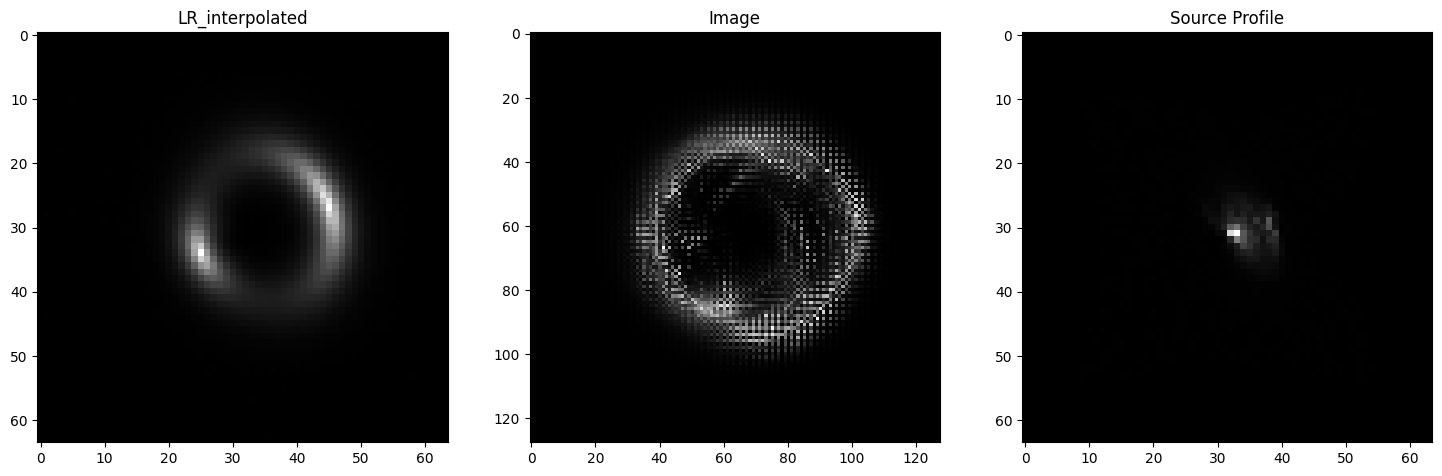

In [9]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

### The training sequence
The model is trained over the set number of epochs over the training images, and subsequently validated on the validation set. For both, the deflection angle given by the model is used to perform lensing, and is trained in an unsupervised manner by imposing the lensing system's constraints. Since the loss module is composed of various components, each of them is tracked for further study if required.

In [10]:
# Training Sequence

best_val_loss = np.inf
best_weights = None
best_delta_weights = None
history = {'val_loss':[], 'loss':[], 'images':[], 'lr':[], 'source':[], 'c_loss':[], 'c_val_loss':[], 'accs':[], 'val_accs':[]} # tracks the train and val losses and training results at each epoch
for epoch in range(EPOCHS):
    losses = []
    classifier_losses = []
    accs = []
    alpha_model.train()
    alpha_delta_model.train()
    classifier.train()
    for i,(x, label) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x, label) = (x.float().to(device), label.to(device))
        alpha_r = alpha_model(x)
        alpha_r = alpha_scaling(alpha_r)
        alpha_delta = alpha_delta_model(x)
        alpha_delta = alpha_delta_scaling(alpha_delta)
        loss = lens_loss(alpha_r, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
        class_prediction = classifier(alpha_delta)
        classifier_loss = classifier_criterion(class_prediction, label)
        I_lens, _, _ = lens_loss.get_sample(alpha_r.detach() + alpha_delta, x, plot=False)
        LR_interpolated = torch.nn.functional.interpolate(x, scale_factor = 2, mode='bicubic')
        classifier_loss += torch.nn.functional.mse_loss(LR_interpolated, I_lens)
        opt_classifier.zero_grad()
        classifier_loss.backward()
        opt_classifier.step()
        classifier_losses.append(float(classifier_loss))
        prediction_indices = torch.argmax(class_prediction, 1)
        acc = float(torch.sum(label == prediction_indices))/float(len(label))
        accs.append(float(acc))
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} and acc {np.mean(accs)} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses))
    history['c_loss'].append(np.mean(classifier_losses))
    history['accs'].append(np.mean(accs))

    alpha_model.eval()
    alpha_delta_model.eval()
    classifier.eval()
    losses = []
    classifier_losses = []
    accs = []
    for i,(x, label) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch+1}")):
        (x, label) = (x.float().to(device), label.to(device))
        alpha_r = alpha_model(x)
        alpha_r = alpha_scaling(alpha_r)
        alpha_delta = alpha_delta_model(x)
        alpha_delta = alpha_delta_scaling(alpha_delta)
        val_loss = lens_loss(alpha_r, x)
        losses.append(float(val_loss))
        class_prediction = classifier(alpha_delta)
        classifier_loss = classifier_criterion(class_prediction, label)
        I_lens, _, _ = lens_loss.get_sample(alpha_r.detach() + alpha_delta, x, plot=False)
        LR_interpolated = torch.nn.functional.interpolate(x, scale_factor = 2, mode='bicubic')
        classifier_loss += torch.nn.functional.mse_loss(LR_interpolated, I_lens)
        classifier_losses.append(float(classifier_loss))
        prediction_indices = torch.argmax(class_prediction, 1)
        acc = float(torch.sum(label == prediction_indices))/float(len(label))
        accs.append(float(acc))
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = alpha_model.state_dict()
        best_delta_weights = alpha_delta_model.state_dict()
    history['val_loss'].append(np.mean(losses))
    history['c_val_loss'].append(np.mean(classifier_losses))
    history['val_accs'].append(np.mean(accs))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} and acc {np.mean(accs)} at LR={opt.param_groups[0]['lr']}")

Training epoch 1:   0%|          | 0/816 [00:00<?, ?it/s]

Training epoch 1: 100%|██████████| 816/816 [01:05<00:00, 12.43it/s]


Training at epoch 1/200: 0.06554248782933927 and acc 0.34558823529411764 at LR=1e-05


Validation epoch 1: 100%|██████████| 204/204 [00:06<00:00, 30.85it/s]


Validation at epoch 1/200: 0.050610054156505595 and acc 0.34411764705882353 at LR=1e-05


Training epoch 2: 100%|██████████| 816/816 [01:09<00:00, 11.68it/s]


Training at epoch 2/200: 0.0486411169792215 and acc 0.3465686274509804 at LR=1e-05


Validation epoch 2: 100%|██████████| 204/204 [00:07<00:00, 28.74it/s]


Validation at epoch 2/200: 0.04655412190100726 and acc 0.34411764705882364 at LR=1e-05


Training epoch 3: 100%|██████████| 816/816 [01:13<00:00, 11.09it/s]


Training at epoch 3/200: 0.04554922265621523 and acc 0.42769607843137253 at LR=1e-05


Validation epoch 3: 100%|██████████| 204/204 [00:07<00:00, 28.31it/s]


Validation at epoch 3/200: 0.04308834984241163 and acc 0.6019607843137255 at LR=1e-05


Training epoch 4: 100%|██████████| 816/816 [01:15<00:00, 10.87it/s]


Training at epoch 4/200: 0.042273210831826516 and acc 0.633578431372549 at LR=1e-05


Validation epoch 4: 100%|██████████| 204/204 [00:07<00:00, 27.46it/s]


Validation at epoch 4/200: 0.04044205076335108 and acc 0.688235294117647 at LR=1e-05


Training epoch 5: 100%|██████████| 816/816 [01:15<00:00, 10.75it/s]


Training at epoch 5/200: 0.037266964086002725 and acc 0.6757352941176472 at LR=1e-05


Validation epoch 5: 100%|██████████| 204/204 [00:07<00:00, 26.26it/s]


Validation at epoch 5/200: 0.03204375727321295 and acc 0.6598039215686274 at LR=1e-05


Training epoch 6: 100%|██████████| 816/816 [01:16<00:00, 10.72it/s]


Training at epoch 6/200: 0.027759833583224786 and acc 0.7088235294117646 at LR=1e-05


Validation epoch 6: 100%|██████████| 204/204 [00:07<00:00, 27.63it/s]


Validation at epoch 6/200: 0.023340692469740614 and acc 0.7470588235294117 at LR=1e-05


Training epoch 7: 100%|██████████| 816/816 [01:16<00:00, 10.67it/s]


Training at epoch 7/200: 0.02377052007895876 and acc 0.7443627450980393 at LR=1e-05


Validation epoch 7: 100%|██████████| 204/204 [00:07<00:00, 27.18it/s]


Validation at epoch 7/200: 0.02409004586675734 and acc 0.6431372549019607 at LR=1e-05


Training epoch 8: 100%|██████████| 816/816 [01:16<00:00, 10.63it/s]


Training at epoch 8/200: 0.021643793371314293 and acc 0.7727941176470589 at LR=1e-05


Validation epoch 8: 100%|██████████| 204/204 [00:07<00:00, 27.33it/s]


Validation at epoch 8/200: 0.02031134712674162 and acc 0.8186274509803921 at LR=1e-05


Training epoch 9: 100%|██████████| 816/816 [01:16<00:00, 10.60it/s]


Training at epoch 9/200: 0.02008721009627277 and acc 0.7852941176470588 at LR=1e-05


Validation epoch 9: 100%|██████████| 204/204 [00:07<00:00, 27.54it/s]


Validation at epoch 9/200: 0.01922856911322942 and acc 0.8254901960784314 at LR=1e-05


Training epoch 10: 100%|██████████| 816/816 [01:17<00:00, 10.53it/s]


Training at epoch 10/200: 0.01937209574537644 and acc 0.8105392156862746 at LR=1e-05


Validation epoch 10: 100%|██████████| 204/204 [00:07<00:00, 27.60it/s]


Validation at epoch 10/200: 0.019224715017366643 and acc 0.8519607843137255 at LR=1e-05


Training epoch 11: 100%|██████████| 816/816 [01:17<00:00, 10.47it/s]


Training at epoch 11/200: 0.018763330661207802 and acc 0.824264705882353 at LR=1e-05


Validation epoch 11: 100%|██████████| 204/204 [00:07<00:00, 27.56it/s]


Validation at epoch 11/200: 0.018393852108833837 and acc 0.7823529411764705 at LR=1e-05


Training epoch 12: 100%|██████████| 816/816 [01:17<00:00, 10.56it/s]


Training at epoch 12/200: 0.018313788734696003 and acc 0.8360294117647059 at LR=1e-05


Validation epoch 12: 100%|██████████| 204/204 [00:07<00:00, 27.18it/s]


Validation at epoch 12/200: 0.018866032485247534 and acc 0.8960784313725491 at LR=1e-05


Training epoch 13: 100%|██████████| 816/816 [01:17<00:00, 10.47it/s]


Training at epoch 13/200: 0.018015573319394653 and acc 0.8522058823529411 at LR=1e-05


Validation epoch 13: 100%|██████████| 204/204 [00:07<00:00, 27.03it/s]


Validation at epoch 13/200: 0.017924945883672026 and acc 0.8431372549019608 at LR=1e-05


Training epoch 14: 100%|██████████| 816/816 [01:17<00:00, 10.58it/s]


Training at epoch 14/200: 0.017595976930084255 and acc 0.8551470588235295 at LR=1e-05


Validation epoch 14: 100%|██████████| 204/204 [00:07<00:00, 26.87it/s]


Validation at epoch 14/200: 0.018164394907288106 and acc 0.8892156862745099 at LR=1e-05


Training epoch 15: 100%|██████████| 816/816 [01:17<00:00, 10.58it/s]


Training at epoch 15/200: 0.01721020810552599 and acc 0.8541666666666666 at LR=1e-05


Validation epoch 15: 100%|██████████| 204/204 [00:07<00:00, 27.43it/s]


Validation at epoch 15/200: 0.017589450174686955 and acc 0.8970588235294118 at LR=1e-05


Training epoch 16: 100%|██████████| 816/816 [01:17<00:00, 10.50it/s]


Training at epoch 16/200: 0.017024732230222037 and acc 0.8622549019607844 at LR=1e-05


Validation epoch 16: 100%|██████████| 204/204 [00:07<00:00, 27.36it/s]


Validation at epoch 16/200: 0.016768981643276764 and acc 0.7009803921568627 at LR=1e-05


Training epoch 17: 100%|██████████| 816/816 [01:17<00:00, 10.49it/s]


Training at epoch 17/200: 0.016733557999353197 and acc 0.8617647058823529 at LR=1e-05


Validation epoch 17: 100%|██████████| 204/204 [00:07<00:00, 27.43it/s]


Validation at epoch 17/200: 0.016737742052760487 and acc 0.896078431372549 at LR=1e-05


Training epoch 18: 100%|██████████| 816/816 [01:18<00:00, 10.46it/s]


Training at epoch 18/200: 0.01655761576508738 and acc 0.8696078431372549 at LR=1e-05


Validation epoch 18: 100%|██████████| 204/204 [00:07<00:00, 27.06it/s]


Validation at epoch 18/200: 0.0167600339981636 and acc 0.8852941176470589 at LR=1e-05


Training epoch 19: 100%|██████████| 816/816 [01:18<00:00, 10.44it/s]


Training at epoch 19/200: 0.016426949931865595 and acc 0.875 at LR=1e-05


Validation epoch 19: 100%|██████████| 204/204 [00:07<00:00, 27.46it/s]


Validation at epoch 19/200: 0.016198806455541476 and acc 0.9205882352941177 at LR=1e-05


Training epoch 20: 100%|██████████| 816/816 [01:17<00:00, 10.50it/s]


Training at epoch 20/200: 0.01595052502656757 and acc 0.8732843137254902 at LR=1e-05


Validation epoch 20: 100%|██████████| 204/204 [00:07<00:00, 27.67it/s]


Validation at epoch 20/200: 0.017482832128949025 and acc 0.9147058823529411 at LR=1e-05


Training epoch 21: 100%|██████████| 816/816 [01:17<00:00, 10.52it/s]


Training at epoch 21/200: 0.01572934950829721 and acc 0.8764705882352942 at LR=1e-05


Validation epoch 21: 100%|██████████| 204/204 [00:07<00:00, 27.54it/s]


Validation at epoch 21/200: 0.01576420213278456 and acc 0.8049019607843139 at LR=1e-05


Training epoch 22: 100%|██████████| 816/816 [01:18<00:00, 10.40it/s]


Training at epoch 22/200: 0.015410297474933459 and acc 0.8921568627450981 at LR=1e-05


Validation epoch 22: 100%|██████████| 204/204 [00:07<00:00, 27.66it/s]


Validation at epoch 22/200: 0.015548444626962437 and acc 0.9088235294117646 at LR=1e-05


Training epoch 23: 100%|██████████| 816/816 [01:17<00:00, 10.50it/s]


Training at epoch 23/200: 0.0152490421622882 and acc 0.8855392156862746 at LR=1e-05


Validation epoch 23: 100%|██████████| 204/204 [00:07<00:00, 27.53it/s]


Validation at epoch 23/200: 0.015089429102326725 and acc 0.8539215686274509 at LR=1e-05


Training epoch 24: 100%|██████████| 816/816 [01:17<00:00, 10.50it/s]


Training at epoch 24/200: 0.014864830887995149 and acc 0.8857843137254902 at LR=1e-05


Validation epoch 24: 100%|██████████| 204/204 [00:07<00:00, 27.52it/s]


Validation at epoch 24/200: 0.015407668876315594 and acc 0.918627450980392 at LR=1e-05


Training epoch 25: 100%|██████████| 816/816 [01:17<00:00, 10.49it/s]


Training at epoch 25/200: 0.014612925212656823 and acc 0.8862745098039216 at LR=1e-05


Validation epoch 25: 100%|██████████| 204/204 [00:07<00:00, 27.25it/s]


Validation at epoch 25/200: 0.014780271885113097 and acc 0.8813725490196077 at LR=1e-05


Training epoch 26: 100%|██████████| 816/816 [01:17<00:00, 10.58it/s]


Training at epoch 26/200: 0.014313811848314442 and acc 0.8931372549019608 at LR=1e-05


Validation epoch 26: 100%|██████████| 204/204 [00:07<00:00, 27.52it/s]


Validation at epoch 26/200: 0.013964015721142585 and acc 0.903921568627451 at LR=1e-05


Training epoch 27: 100%|██████████| 816/816 [01:18<00:00, 10.37it/s]


Training at epoch 27/200: 0.014146756545147476 and acc 0.8970588235294118 at LR=1e-05


Validation epoch 27: 100%|██████████| 204/204 [00:07<00:00, 27.33it/s]


Validation at epoch 27/200: 0.014006124341440405 and acc 0.9029411764705881 at LR=1e-05


Training epoch 28: 100%|██████████| 816/816 [01:17<00:00, 10.52it/s]


Training at epoch 28/200: 0.013896951180832534 and acc 0.8958333333333334 at LR=1e-05


Validation epoch 28: 100%|██████████| 204/204 [00:07<00:00, 27.39it/s]


Validation at epoch 28/200: 0.013712485195320173 and acc 0.9019607843137255 at LR=1e-05


Training epoch 29: 100%|██████████| 816/816 [01:18<00:00, 10.44it/s]


Training at epoch 29/200: 0.013741943212545604 and acc 0.9017156862745099 at LR=1e-05


Validation epoch 29: 100%|██████████| 204/204 [00:07<00:00, 27.51it/s]


Validation at epoch 29/200: 0.0130937908680233 and acc 0.8578431372549019 at LR=1e-05


Training epoch 30: 100%|██████████| 816/816 [01:17<00:00, 10.47it/s]


Training at epoch 30/200: 0.013622814913819014 and acc 0.8848039215686276 at LR=1e-05


Validation epoch 30: 100%|██████████| 204/204 [00:07<00:00, 27.82it/s]


Validation at epoch 30/200: 0.01301841853944329 and acc 0.9107843137254903 at LR=1e-05


Training epoch 31: 100%|██████████| 816/816 [01:17<00:00, 10.48it/s]


Training at epoch 31/200: 0.013583625045344782 and acc 0.9022058823529412 at LR=1e-05


Validation epoch 31: 100%|██████████| 204/204 [00:07<00:00, 26.98it/s]


Validation at epoch 31/200: 0.013190896592705566 and acc 0.8764705882352942 at LR=1e-05


Training epoch 32: 100%|██████████| 816/816 [01:18<00:00, 10.44it/s]


Training at epoch 32/200: 0.013039040478521629 and acc 0.8975490196078433 at LR=1e-05


Validation epoch 32: 100%|██████████| 204/204 [00:07<00:00, 27.49it/s]


Validation at epoch 32/200: 0.012875509756507681 and acc 0.8911764705882352 at LR=1e-05


Training epoch 33: 100%|██████████| 816/816 [01:18<00:00, 10.43it/s]


Training at epoch 33/200: 0.012989548547421674 and acc 0.9000000000000001 at LR=1e-05


Validation epoch 33: 100%|██████████| 204/204 [00:07<00:00, 27.22it/s]


Validation at epoch 33/200: 0.012689447265538369 and acc 0.907843137254902 at LR=1e-05


Training epoch 34: 100%|██████████| 816/816 [01:17<00:00, 10.47it/s]


Training at epoch 34/200: 0.012787784748783736 and acc 0.9083333333333334 at LR=1e-05


Validation epoch 34: 100%|██████████| 204/204 [00:07<00:00, 27.65it/s]


Validation at epoch 34/200: 0.012985202842209415 and acc 0.9205882352941177 at LR=1e-05


Training epoch 35: 100%|██████████| 816/816 [01:17<00:00, 10.49it/s]


Training at epoch 35/200: 0.012658940645861531 and acc 0.903921568627451 at LR=1e-05


Validation epoch 35: 100%|██████████| 204/204 [00:07<00:00, 27.55it/s]


Validation at epoch 35/200: 0.012507707181879702 and acc 0.9019607843137256 at LR=1e-05


Training epoch 36: 100%|██████████| 816/816 [01:17<00:00, 10.47it/s]


Training at epoch 36/200: 0.012473081412620149 and acc 0.9129901960784313 at LR=1e-05


Validation epoch 36: 100%|██████████| 204/204 [00:07<00:00, 27.16it/s]


Validation at epoch 36/200: 0.01256954784085061 and acc 0.903921568627451 at LR=1e-05


Training epoch 37: 100%|██████████| 816/816 [01:18<00:00, 10.46it/s]


Training at epoch 37/200: 0.01233227367800496 and acc 0.9000000000000001 at LR=1e-05


Validation epoch 37: 100%|██████████| 204/204 [00:07<00:00, 27.64it/s]


Validation at epoch 37/200: 0.012695489782273915 and acc 0.9147058823529411 at LR=1e-05


Training epoch 38: 100%|██████████| 816/816 [01:17<00:00, 10.49it/s]


Training at epoch 38/200: 0.012203717565474411 and acc 0.9178921568627451 at LR=1e-05


Validation epoch 38: 100%|██████████| 204/204 [00:07<00:00, 27.54it/s]


Validation at epoch 38/200: 0.012793017946201943 and acc 0.9303921568627451 at LR=1e-05


Training epoch 39: 100%|██████████| 816/816 [01:17<00:00, 10.51it/s]


Training at epoch 39/200: 0.012116105394442474 and acc 0.9151960784313726 at LR=1e-05


Validation epoch 39: 100%|██████████| 204/204 [00:07<00:00, 27.30it/s]


Validation at epoch 39/200: 0.01228102271481618 and acc 0.888235294117647 at LR=1e-05


Training epoch 40: 100%|██████████| 816/816 [01:17<00:00, 10.48it/s]


Training at epoch 40/200: 0.012019697474612507 and acc 0.9200980392156862 at LR=1e-05


Validation epoch 40: 100%|██████████| 204/204 [00:07<00:00, 27.14it/s]


Validation at epoch 40/200: 0.01229672289143006 and acc 0.9019607843137255 at LR=1e-05


Training epoch 41: 100%|██████████| 816/816 [01:17<00:00, 10.52it/s]


Training at epoch 41/200: 0.011895703825775497 and acc 0.9193627450980393 at LR=1e-05


Validation epoch 41: 100%|██████████| 204/204 [00:07<00:00, 27.35it/s]


Validation at epoch 41/200: 0.012430943350088508 and acc 0.888235294117647 at LR=1e-05


Training epoch 42: 100%|██████████| 816/816 [01:17<00:00, 10.49it/s]


Training at epoch 42/200: 0.011774203648183532 and acc 0.9186274509803922 at LR=1e-05


Validation epoch 42: 100%|██████████| 204/204 [00:07<00:00, 26.92it/s]


Validation at epoch 42/200: 0.011403208046092414 and acc 0.8980392156862744 at LR=1e-05


Training epoch 43: 100%|██████████| 816/816 [01:18<00:00, 10.34it/s]


Training at epoch 43/200: 0.011833391344065176 and acc 0.9147058823529413 at LR=1e-05


Validation epoch 43: 100%|██████████| 204/204 [00:07<00:00, 27.24it/s]


Validation at epoch 43/200: 0.0118580471801882 and acc 0.9235294117647058 at LR=1e-05


Training epoch 44: 100%|██████████| 816/816 [01:17<00:00, 10.55it/s]


Training at epoch 44/200: 0.0115820855494616 and acc 0.9144607843137256 at LR=1e-05


Validation epoch 44: 100%|██████████| 204/204 [00:07<00:00, 27.34it/s]


Validation at epoch 44/200: 0.011830855759006798 and acc 0.9264705882352942 at LR=1e-05


Training epoch 45: 100%|██████████| 816/816 [01:17<00:00, 10.56it/s]


Training at epoch 45/200: 0.011528559511883514 and acc 0.9252450980392157 at LR=1e-05


Validation epoch 45: 100%|██████████| 204/204 [00:07<00:00, 27.23it/s]


Validation at epoch 45/200: 0.011250373578685172 and acc 0.9039215686274509 at LR=1e-05


Training epoch 46: 100%|██████████| 816/816 [01:17<00:00, 10.49it/s]


Training at epoch 46/200: 0.01130773545032842 and acc 0.9264705882352942 at LR=1e-05


Validation epoch 46: 100%|██████████| 204/204 [00:07<00:00, 27.03it/s]


Validation at epoch 46/200: 0.011393719592460376 and acc 0.9372549019607842 at LR=1e-05


Training epoch 47: 100%|██████████| 816/816 [01:17<00:00, 10.51it/s]


Training at epoch 47/200: 0.011254603106542216 and acc 0.9208333333333334 at LR=1e-05


Validation epoch 47: 100%|██████████| 204/204 [00:07<00:00, 27.22it/s]


Validation at epoch 47/200: 0.0110775928821086 and acc 0.8862745098039215 at LR=1e-05


Training epoch 48: 100%|██████████| 816/816 [01:18<00:00, 10.45it/s]


Training at epoch 48/200: 0.011512927804598767 and acc 0.9296568627450982 at LR=1e-05


Validation epoch 48: 100%|██████████| 204/204 [00:07<00:00, 27.01it/s]


Validation at epoch 48/200: 0.011472860930998828 and acc 0.9372549019607842 at LR=1e-05


Training epoch 49: 100%|██████████| 816/816 [01:17<00:00, 10.49it/s]


Training at epoch 49/200: 0.011183434386290245 and acc 0.9264705882352942 at LR=1e-05


Validation epoch 49: 100%|██████████| 204/204 [00:07<00:00, 27.22it/s]


Validation at epoch 49/200: 0.010826442196654776 and acc 0.9401960784313727 at LR=1e-05


Training epoch 50: 100%|██████████| 816/816 [01:18<00:00, 10.41it/s]


Training at epoch 50/200: 0.010899187196342858 and acc 0.9259803921568628 at LR=1e-05


Validation epoch 50: 100%|██████████| 204/204 [00:07<00:00, 27.56it/s]


Validation at epoch 50/200: 0.010896954331638328 and acc 0.938235294117647 at LR=1e-05


Training epoch 51: 100%|██████████| 816/816 [01:17<00:00, 10.54it/s]


Training at epoch 51/200: 0.010772562593189707 and acc 0.925735294117647 at LR=1e-05


Validation epoch 51: 100%|██████████| 204/204 [00:07<00:00, 27.27it/s]


Validation at epoch 51/200: 0.010861175851531181 and acc 0.8823529411764706 at LR=1e-05


Training epoch 52: 100%|██████████| 816/816 [01:17<00:00, 10.52it/s]


Training at epoch 52/200: 0.010646234072434405 and acc 0.9355392156862746 at LR=1e-05


Validation epoch 52: 100%|██████████| 204/204 [00:07<00:00, 27.42it/s]


Validation at epoch 52/200: 0.010545350718494578 and acc 0.9225490196078431 at LR=1e-05


Training epoch 53: 100%|██████████| 816/816 [01:18<00:00, 10.46it/s]


Training at epoch 53/200: 0.010499208057915573 and acc 0.9313725490196079 at LR=1e-05


Validation epoch 53: 100%|██████████| 204/204 [00:07<00:00, 26.88it/s]


Validation at epoch 53/200: 0.010461335625116001 and acc 0.9235294117647059 at LR=1e-05


Training epoch 54: 100%|██████████| 816/816 [01:17<00:00, 10.49it/s]


Training at epoch 54/200: 0.010675220848997032 and acc 0.9269607843137254 at LR=1e-05


Validation epoch 54: 100%|██████████| 204/204 [00:07<00:00, 27.25it/s]


Validation at epoch 54/200: 0.010112041954462435 and acc 0.8431372549019608 at LR=1e-05


Training epoch 55: 100%|██████████| 816/816 [01:17<00:00, 10.56it/s]


Training at epoch 55/200: 0.010245004698506319 and acc 0.9377450980392158 at LR=1e-05


Validation epoch 55: 100%|██████████| 204/204 [00:07<00:00, 27.27it/s]


Validation at epoch 55/200: 0.010033527809176958 and acc 0.9137254901960783 at LR=1e-05


Training epoch 56: 100%|██████████| 816/816 [01:20<00:00, 10.18it/s]


Training at epoch 56/200: 0.009968912022932451 and acc 0.9318627450980393 at LR=1e-05


Validation epoch 56: 100%|██████████| 204/204 [00:07<00:00, 27.64it/s]


Validation at epoch 56/200: 0.009526266969795175 and acc 0.8892156862745099 at LR=1e-05


Training epoch 57: 100%|██████████| 816/816 [01:11<00:00, 11.39it/s]


Training at epoch 57/200: 0.009689817291241614 and acc 0.9355392156862746 at LR=1e-05


Validation epoch 57: 100%|██████████| 204/204 [00:07<00:00, 28.44it/s]


Validation at epoch 57/200: 0.00930003571899279 and acc 0.9284313725490196 at LR=1e-05


Training epoch 58: 100%|██████████| 816/816 [01:10<00:00, 11.57it/s]


Training at epoch 58/200: 0.00974714775471583 and acc 0.9392156862745099 at LR=1e-05


Validation epoch 58: 100%|██████████| 204/204 [00:06<00:00, 29.90it/s]


Validation at epoch 58/200: 0.009861809922857028 and acc 0.9431372549019607 at LR=1e-05


Training epoch 59: 100%|██████████| 816/816 [01:09<00:00, 11.74it/s]


Training at epoch 59/200: 0.00948531087830334 and acc 0.9428921568627452 at LR=1e-05


Validation epoch 59: 100%|██████████| 204/204 [00:06<00:00, 29.47it/s]


Validation at epoch 59/200: 0.009419353482514327 and acc 0.9480392156862746 at LR=1e-05


Training epoch 60: 100%|██████████| 816/816 [01:09<00:00, 11.66it/s]


Training at epoch 60/200: 0.009335871974198037 and acc 0.9377450980392158 at LR=1e-05


Validation epoch 60: 100%|██████████| 204/204 [00:07<00:00, 28.64it/s]


Validation at epoch 60/200: 0.009216590300567594 and acc 0.9215686274509803 at LR=1e-05


Training epoch 61: 100%|██████████| 816/816 [01:12<00:00, 11.21it/s]


Training at epoch 61/200: 0.009164564621945223 and acc 0.9411764705882353 at LR=1e-05


Validation epoch 61: 100%|██████████| 204/204 [00:07<00:00, 28.55it/s]


Validation at epoch 61/200: 0.009340494727332364 and acc 0.9274509803921568 at LR=1e-05


Training epoch 62: 100%|██████████| 816/816 [01:14<00:00, 10.93it/s]


Training at epoch 62/200: 0.009085941941628014 and acc 0.9463235294117648 at LR=1e-05


Validation epoch 62: 100%|██████████| 204/204 [00:07<00:00, 28.19it/s]


Validation at epoch 62/200: 0.008886515681047504 and acc 0.9284313725490196 at LR=1e-05


Training epoch 63: 100%|██████████| 816/816 [01:14<00:00, 10.98it/s]


Training at epoch 63/200: 0.008953660068001744 and acc 0.9465686274509805 at LR=1e-05


Validation epoch 63: 100%|██████████| 204/204 [00:07<00:00, 27.55it/s]


Validation at epoch 63/200: 0.00861599064185558 and acc 0.9235294117647058 at LR=1e-05


Training epoch 64: 100%|██████████| 816/816 [01:13<00:00, 11.09it/s]


Training at epoch 64/200: 0.008706400217716674 and acc 0.9441176470588236 at LR=1e-05


Validation epoch 64: 100%|██████████| 204/204 [00:07<00:00, 27.90it/s]


Validation at epoch 64/200: 0.008704297634882523 and acc 0.8637254901960784 at LR=1e-05


Training epoch 65: 100%|██████████| 816/816 [01:13<00:00, 11.04it/s]


Training at epoch 65/200: 0.008893125300186084 and acc 0.9424019607843137 at LR=1e-05


Validation epoch 65: 100%|██████████| 204/204 [00:07<00:00, 28.52it/s]


Validation at epoch 65/200: 0.008728723847489878 and acc 0.9205882352941177 at LR=1e-05


Training epoch 66: 100%|██████████| 816/816 [01:12<00:00, 11.19it/s]


Training at epoch 66/200: 0.008453622040357076 and acc 0.9428921568627451 at LR=1e-05


Validation epoch 66: 100%|██████████| 204/204 [00:07<00:00, 27.62it/s]


Validation at epoch 66/200: 0.008361617604261446 and acc 0.9215686274509803 at LR=1e-05


Training epoch 67: 100%|██████████| 816/816 [01:11<00:00, 11.36it/s]


Training at epoch 67/200: 0.008366598925717613 and acc 0.9487745098039216 at LR=1e-05


Validation epoch 67: 100%|██████████| 204/204 [00:06<00:00, 29.76it/s]


Validation at epoch 67/200: 0.008584782855548695 and acc 0.7980392156862746 at LR=1e-05


Training epoch 68: 100%|██████████| 816/816 [01:09<00:00, 11.75it/s]


Training at epoch 68/200: 0.008239315444370732 and acc 0.9495098039215686 at LR=1e-05


Validation epoch 68: 100%|██████████| 204/204 [00:06<00:00, 29.34it/s]


Validation at epoch 68/200: 0.008300975250427192 and acc 0.942156862745098 at LR=1e-05


Training epoch 69: 100%|██████████| 816/816 [01:09<00:00, 11.78it/s]


Training at epoch 69/200: 0.008324172785482826 and acc 0.9458333333333334 at LR=1e-05


Validation epoch 69: 100%|██████████| 204/204 [00:06<00:00, 29.98it/s]


Validation at epoch 69/200: 0.008149537741772685 and acc 0.8578431372549019 at LR=1e-05


Training epoch 70: 100%|██████████| 816/816 [01:08<00:00, 11.83it/s]


Training at epoch 70/200: 0.008273641187378078 and acc 0.9455882352941178 at LR=1e-05


Validation epoch 70: 100%|██████████| 204/204 [00:06<00:00, 30.15it/s]


Validation at epoch 70/200: 0.0077001013023797055 and acc 0.9627450980392157 at LR=1e-05


Training epoch 71: 100%|██████████| 816/816 [01:09<00:00, 11.66it/s]


Training at epoch 71/200: 0.008145460152459861 and acc 0.9504901960784314 at LR=1e-05


Validation epoch 71: 100%|██████████| 204/204 [00:06<00:00, 29.37it/s]


Validation at epoch 71/200: 0.008502239604507956 and acc 0.8794117647058823 at LR=1e-05


Training epoch 72: 100%|██████████| 816/816 [01:10<00:00, 11.64it/s]


Training at epoch 72/200: 0.007906396998841242 and acc 0.9490196078431372 at LR=1e-05


Validation epoch 72: 100%|██████████| 204/204 [00:06<00:00, 29.28it/s]


Validation at epoch 72/200: 0.00780991355970721 and acc 0.9598039215686275 at LR=1e-05


Training epoch 73: 100%|██████████| 816/816 [01:09<00:00, 11.67it/s]


Training at epoch 73/200: 0.00766913410773793 and acc 0.9463235294117648 at LR=1e-05


Validation epoch 73: 100%|██████████| 204/204 [00:06<00:00, 29.91it/s]


Validation at epoch 73/200: 0.00776757324666844 and acc 0.9519607843137255 at LR=1e-05


Training epoch 74: 100%|██████████| 816/816 [01:09<00:00, 11.71it/s]


Training at epoch 74/200: 0.00800415774517437 and acc 0.9549019607843138 at LR=1e-05


Validation epoch 74: 100%|██████████| 204/204 [00:06<00:00, 29.36it/s]


Validation at epoch 74/200: 0.007587445664730873 and acc 0.7186274509803922 at LR=1e-05


Training epoch 75: 100%|██████████| 816/816 [01:09<00:00, 11.73it/s]


Training at epoch 75/200: 0.007713539961853302 and acc 0.9524509803921569 at LR=1e-05


Validation epoch 75: 100%|██████████| 204/204 [00:07<00:00, 29.07it/s]


Validation at epoch 75/200: 0.007487028719647331 and acc 0.9500000000000001 at LR=1e-05


Training epoch 76: 100%|██████████| 816/816 [01:09<00:00, 11.80it/s]


Training at epoch 76/200: 0.007523929637197095 and acc 0.9556372549019608 at LR=1e-05


Validation epoch 76: 100%|██████████| 204/204 [00:06<00:00, 29.72it/s]


Validation at epoch 76/200: 0.007482593643990364 and acc 0.9558823529411765 at LR=1e-05


Training epoch 77: 100%|██████████| 816/816 [01:09<00:00, 11.78it/s]


Training at epoch 77/200: 0.007518705806932321 and acc 0.9450980392156864 at LR=1e-05


Validation epoch 77: 100%|██████████| 204/204 [00:06<00:00, 29.66it/s]


Validation at epoch 77/200: 0.0074720287560850526 and acc 0.9509803921568627 at LR=1e-05


Training epoch 78: 100%|██████████| 816/816 [01:10<00:00, 11.63it/s]


Training at epoch 78/200: 0.007438703130259562 and acc 0.9536764705882353 at LR=1e-05


Validation epoch 78: 100%|██████████| 204/204 [00:06<00:00, 29.50it/s]


Validation at epoch 78/200: 0.007943814198084759 and acc 0.9264705882352942 at LR=1e-05


Training epoch 79: 100%|██████████| 816/816 [01:09<00:00, 11.74it/s]


Training at epoch 79/200: 0.007326762927821655 and acc 0.9497549019607843 at LR=1e-05


Validation epoch 79: 100%|██████████| 204/204 [00:06<00:00, 29.71it/s]


Validation at epoch 79/200: 0.0074807991771319625 and acc 0.830392156862745 at LR=1e-05


Training epoch 80: 100%|██████████| 816/816 [01:09<00:00, 11.79it/s]


Training at epoch 80/200: 0.007286465217190448 and acc 0.9573529411764706 at LR=1e-05


Validation epoch 80: 100%|██████████| 204/204 [00:06<00:00, 29.71it/s]


Validation at epoch 80/200: 0.00704001691808705 and acc 0.9568627450980391 at LR=1e-05


Training epoch 81: 100%|██████████| 816/816 [01:09<00:00, 11.72it/s]


Training at epoch 81/200: 0.007140508367549902 and acc 0.9612745098039216 at LR=1e-05


Validation epoch 81: 100%|██████████| 204/204 [00:06<00:00, 29.58it/s]


Validation at epoch 81/200: 0.007088987722846807 and acc 0.9392156862745098 at LR=1e-05


Training epoch 82: 100%|██████████| 816/816 [01:09<00:00, 11.75it/s]


Training at epoch 82/200: 0.007015255627087683 and acc 0.9556372549019607 at LR=1e-05


Validation epoch 82: 100%|██████████| 204/204 [00:06<00:00, 29.38it/s]


Validation at epoch 82/200: 0.006863014615031288 and acc 0.8990196078431373 at LR=1e-05


Training epoch 83: 100%|██████████| 816/816 [01:09<00:00, 11.77it/s]


Training at epoch 83/200: 0.00694427486793275 and acc 0.9546568627450981 at LR=1e-05


Validation epoch 83: 100%|██████████| 204/204 [00:06<00:00, 30.46it/s]


Validation at epoch 83/200: 0.007026637467217869 and acc 0.9549019607843138 at LR=1e-05


Training epoch 84: 100%|██████████| 816/816 [01:07<00:00, 12.05it/s]


Training at epoch 84/200: 0.006546134961479088 and acc 0.9625000000000001 at LR=1e-05


Validation epoch 84: 100%|██████████| 204/204 [00:06<00:00, 30.93it/s]


Validation at epoch 84/200: 0.006754947251037639 and acc 0.9274509803921568 at LR=1e-05


Training epoch 85: 100%|██████████| 816/816 [01:07<00:00, 12.05it/s]


Training at epoch 85/200: 0.006473239118349738 and acc 0.9497549019607843 at LR=1e-05


Validation epoch 85: 100%|██████████| 204/204 [00:06<00:00, 30.84it/s]


Validation at epoch 85/200: 0.007958120228174855 and acc 0.9441176470588236 at LR=1e-05


Training epoch 86: 100%|██████████| 816/816 [01:07<00:00, 12.12it/s]


Training at epoch 86/200: 0.006360424876808846 and acc 0.9468137254901963 at LR=1e-05


Validation epoch 86: 100%|██████████| 204/204 [00:06<00:00, 30.04it/s]


Validation at epoch 86/200: 0.006419593026615022 and acc 0.9372549019607842 at LR=1e-05


Training epoch 87: 100%|██████████| 816/816 [01:07<00:00, 12.01it/s]


Training at epoch 87/200: 0.006195732517345973 and acc 0.9575980392156864 at LR=1e-05


Validation epoch 87: 100%|██████████| 204/204 [00:07<00:00, 28.95it/s]


Validation at epoch 87/200: 0.005957775310996701 and acc 0.9500000000000001 at LR=1e-05


Training epoch 88: 100%|██████████| 816/816 [01:08<00:00, 11.96it/s]


Training at epoch 88/200: 0.0061173185297543654 and acc 0.963970588235294 at LR=1e-05


Validation epoch 88: 100%|██████████| 204/204 [00:06<00:00, 30.80it/s]


Validation at epoch 88/200: 0.006530193188547285 and acc 0.907843137254902 at LR=1e-05


Training epoch 89: 100%|██████████| 816/816 [01:07<00:00, 12.02it/s]


Training at epoch 89/200: 0.005986518736166295 and acc 0.956372549019608 at LR=1e-05


Validation epoch 89: 100%|██████████| 204/204 [00:06<00:00, 29.82it/s]


Validation at epoch 89/200: 0.005810852094060358 and acc 0.9401960784313727 at LR=1e-05


Training epoch 90: 100%|██████████| 816/816 [01:08<00:00, 11.89it/s]


Training at epoch 90/200: 0.005796510656877859 and acc 0.9575980392156862 at LR=1e-05


Validation epoch 90: 100%|██████████| 204/204 [00:06<00:00, 29.51it/s]


Validation at epoch 90/200: 0.005796709357003006 and acc 0.9509803921568627 at LR=1e-05


Training epoch 91: 100%|██████████| 816/816 [01:08<00:00, 11.87it/s]


Training at epoch 91/200: 0.005663466737970856 and acc 0.9553921568627451 at LR=1e-05


Validation epoch 91: 100%|██████████| 204/204 [00:06<00:00, 29.52it/s]


Validation at epoch 91/200: 0.005645363370194009 and acc 0.9490196078431373 at LR=1e-05


Training epoch 92: 100%|██████████| 816/816 [01:08<00:00, 11.98it/s]


Training at epoch 92/200: 0.005537160397758342 and acc 0.9566176470588236 at LR=1e-05


Validation epoch 92: 100%|██████████| 204/204 [00:06<00:00, 30.67it/s]


Validation at epoch 92/200: 0.005699041224194362 and acc 0.9490196078431372 at LR=1e-05


Training epoch 93: 100%|██████████| 816/816 [01:08<00:00, 11.95it/s]


Training at epoch 93/200: 0.005531812175439543 and acc 0.9622549019607843 at LR=1e-05


Validation epoch 93: 100%|██████████| 204/204 [00:07<00:00, 29.13it/s]


Validation at epoch 93/200: 0.0054144510672902504 and acc 0.9529411764705881 at LR=1e-05


Training epoch 94: 100%|██████████| 816/816 [01:09<00:00, 11.80it/s]


Training at epoch 94/200: 0.005598005024926262 and acc 0.9629901960784313 at LR=1e-05


Validation epoch 94: 100%|██████████| 204/204 [00:06<00:00, 29.47it/s]


Validation at epoch 94/200: 0.005269867113526619 and acc 0.9431372549019608 at LR=1e-05


Training epoch 95: 100%|██████████| 816/816 [01:08<00:00, 11.88it/s]


Training at epoch 95/200: 0.005312750896943423 and acc 0.9634803921568628 at LR=1e-05


Validation epoch 95: 100%|██████████| 204/204 [00:06<00:00, 29.89it/s]


Validation at epoch 95/200: 0.00541480232769733 and acc 0.9382352941176471 at LR=1e-05


Training epoch 96: 100%|██████████| 816/816 [01:08<00:00, 11.87it/s]


Training at epoch 96/200: 0.005267359011329473 and acc 0.9634803921568628 at LR=1e-05


Validation epoch 96: 100%|██████████| 204/204 [00:06<00:00, 30.09it/s]


Validation at epoch 96/200: 0.004993348870901209 and acc 0.9607843137254902 at LR=1e-05


Training epoch 97: 100%|██████████| 816/816 [01:08<00:00, 11.85it/s]


Training at epoch 97/200: 0.005156398385046415 and acc 0.9610294117647059 at LR=1e-05


Validation epoch 97: 100%|██████████| 204/204 [00:06<00:00, 29.95it/s]


Validation at epoch 97/200: 0.005227277653437911 and acc 0.9637254901960784 at LR=1e-05


Training epoch 98: 100%|██████████| 816/816 [01:09<00:00, 11.75it/s]


Training at epoch 98/200: 0.005216952537439819 and acc 0.9681372549019608 at LR=1e-05


Validation epoch 98: 100%|██████████| 204/204 [00:06<00:00, 29.39it/s]


Validation at epoch 98/200: 0.006095596995460344 and acc 0.8539215686274509 at LR=1e-05


Training epoch 99: 100%|██████████| 816/816 [01:10<00:00, 11.60it/s]


Training at epoch 99/200: 0.005060768863140587 and acc 0.9639705882352941 at LR=1e-05


Validation epoch 99: 100%|██████████| 204/204 [00:07<00:00, 27.90it/s]


Validation at epoch 99/200: 0.005229102221646291 and acc 0.7176470588235295 at LR=1e-05


Training epoch 100: 100%|██████████| 816/816 [01:14<00:00, 11.00it/s]


Training at epoch 100/200: 0.005093903644592501 and acc 0.9678921568627452 at LR=1e-05


Validation epoch 100: 100%|██████████| 204/204 [00:07<00:00, 27.44it/s]


Validation at epoch 100/200: 0.0053047370530811015 and acc 0.9539215686274509 at LR=1e-05


Training epoch 101: 100%|██████████| 816/816 [01:15<00:00, 10.74it/s]


Training at epoch 101/200: 0.0050529359934586736 and acc 0.9647058823529412 at LR=1e-05


Validation epoch 101: 100%|██████████| 204/204 [00:07<00:00, 26.91it/s]


Validation at epoch 101/200: 0.006708582905440719 and acc 0.9598039215686275 at LR=1e-05


Training epoch 102: 100%|██████████| 816/816 [01:19<00:00, 10.22it/s]


Training at epoch 102/200: 0.004975929880838878 and acc 0.9674019607843138 at LR=1e-05


Validation epoch 102: 100%|██████████| 204/204 [00:07<00:00, 26.83it/s]


Validation at epoch 102/200: 0.005586418246749935 and acc 0.9029411764705881 at LR=1e-05


Training epoch 103: 100%|██████████| 816/816 [01:14<00:00, 10.97it/s]


Training at epoch 103/200: 0.005256671998330264 and acc 0.9654411764705884 at LR=1e-05


Validation epoch 103: 100%|██████████| 204/204 [00:07<00:00, 28.76it/s]


Validation at epoch 103/200: 0.005071440572375614 and acc 0.9715686274509805 at LR=1e-05


Training epoch 104: 100%|██████████| 816/816 [01:08<00:00, 11.85it/s]


Training at epoch 104/200: 0.004840809225581824 and acc 0.9676470588235294 at LR=1e-05


Validation epoch 104: 100%|██████████| 204/204 [00:06<00:00, 29.87it/s]


Validation at epoch 104/200: 0.005395258242702659 and acc 0.9450980392156864 at LR=1e-05


Training epoch 105: 100%|██████████| 816/816 [01:07<00:00, 12.15it/s]


Training at epoch 105/200: 0.004966147087044174 and acc 0.9693627450980393 at LR=1e-05


Validation epoch 105: 100%|██████████| 204/204 [00:06<00:00, 30.22it/s]


Validation at epoch 105/200: 0.005438413677563635 and acc 0.8980392156862744 at LR=1e-05


Training epoch 106: 100%|██████████| 816/816 [01:07<00:00, 12.17it/s]


Training at epoch 106/200: 0.004847222693748407 and acc 0.9605392156862745 at LR=1e-05


Validation epoch 106: 100%|██████████| 204/204 [00:06<00:00, 30.07it/s]


Validation at epoch 106/200: 0.004802198504216457 and acc 0.9303921568627451 at LR=1e-05


Training epoch 107: 100%|██████████| 816/816 [01:06<00:00, 12.23it/s]


Training at epoch 107/200: 0.004732218597257766 and acc 0.9698529411764707 at LR=1e-05


Validation epoch 107: 100%|██████████| 204/204 [00:06<00:00, 30.39it/s]


Validation at epoch 107/200: 0.0047777154706601125 and acc 0.9686274509803922 at LR=1e-05


Training epoch 108: 100%|██████████| 816/816 [01:06<00:00, 12.19it/s]


Training at epoch 108/200: 0.004672439083543734 and acc 0.967892156862745 at LR=1e-05


Validation epoch 108: 100%|██████████| 204/204 [00:06<00:00, 30.02it/s]


Validation at epoch 108/200: 0.0046794926833279215 and acc 0.957843137254902 at LR=1e-05


Training epoch 109: 100%|██████████| 816/816 [01:06<00:00, 12.21it/s]


Training at epoch 109/200: 0.00442708219634369 and acc 0.9718137254901961 at LR=1e-05


Validation epoch 109: 100%|██████████| 204/204 [00:06<00:00, 29.96it/s]


Validation at epoch 109/200: 0.0047920530738409465 and acc 0.9607843137254902 at LR=1e-05


Training epoch 110: 100%|██████████| 816/816 [01:06<00:00, 12.20it/s]


Training at epoch 110/200: 0.004245623451995426 and acc 0.9683823529411765 at LR=1e-05


Validation epoch 110: 100%|██████████| 204/204 [00:07<00:00, 28.45it/s]


Validation at epoch 110/200: 0.004415785721457545 and acc 0.969607843137255 at LR=1e-05


Training epoch 111: 100%|██████████| 816/816 [01:07<00:00, 12.18it/s]


Training at epoch 111/200: 0.0042814232087146275 and acc 0.9683823529411765 at LR=1e-05


Validation epoch 111: 100%|██████████| 204/204 [00:06<00:00, 30.06it/s]


Validation at epoch 111/200: 0.004992825040187431 and acc 0.9676470588235293 at LR=1e-05


Training epoch 112: 100%|██████████| 816/816 [01:07<00:00, 12.14it/s]


Training at epoch 112/200: 0.004205623108895915 and acc 0.9752450980392158 at LR=1e-05


Validation epoch 112: 100%|██████████| 204/204 [00:06<00:00, 29.97it/s]


Validation at epoch 112/200: 0.004751899429738485 and acc 0.9637254901960784 at LR=1e-05


Training epoch 113: 100%|██████████| 816/816 [01:06<00:00, 12.25it/s]


Training at epoch 113/200: 0.00409001594337443 and acc 0.9754901960784313 at LR=1e-05


Validation epoch 113: 100%|██████████| 204/204 [00:06<00:00, 30.41it/s]


Validation at epoch 113/200: 0.003991399546423196 and acc 0.9490196078431373 at LR=1e-05


Training epoch 114: 100%|██████████| 816/816 [01:06<00:00, 12.20it/s]


Training at epoch 114/200: 0.004001173853027343 and acc 0.9715686274509804 at LR=1e-05


Validation epoch 114: 100%|██████████| 204/204 [00:06<00:00, 30.45it/s]


Validation at epoch 114/200: 0.0040990268296845185 and acc 0.9656862745098039 at LR=1e-05


Training epoch 115: 100%|██████████| 816/816 [01:06<00:00, 12.26it/s]


Training at epoch 115/200: 0.003925108716893923 and acc 0.9725490196078431 at LR=1e-05


Validation epoch 115: 100%|██████████| 204/204 [00:06<00:00, 30.05it/s]


Validation at epoch 115/200: 0.004398455322313798 and acc 0.9196078431372549 at LR=1e-05


Training epoch 116: 100%|██████████| 816/816 [01:07<00:00, 12.17it/s]


Training at epoch 116/200: 0.0038415495635526183 and acc 0.9769607843137256 at LR=1e-05


Validation epoch 116: 100%|██████████| 204/204 [00:06<00:00, 30.75it/s]


Validation at epoch 116/200: 0.003801190688083058 and acc 0.9362745098039216 at LR=1e-05


Training epoch 117: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 117/200: 0.004140779379453948 and acc 0.9666666666666666 at LR=1e-05


Validation epoch 117: 100%|██████████| 204/204 [00:06<00:00, 30.37it/s]


Validation at epoch 117/200: 0.004267072224619743 and acc 0.9588235294117649 at LR=1e-05


Training epoch 118: 100%|██████████| 816/816 [01:06<00:00, 12.19it/s]


Training at epoch 118/200: 0.0038509277476216942 and acc 0.9674019607843137 at LR=1e-05


Validation epoch 118: 100%|██████████| 204/204 [00:06<00:00, 29.74it/s]


Validation at epoch 118/200: 0.004178198845372261 and acc 0.9598039215686275 at LR=1e-05


Training epoch 119: 100%|██████████| 816/816 [01:07<00:00, 12.18it/s]


Training at epoch 119/200: 0.004111610634044707 and acc 0.9745098039215687 at LR=1e-05


Validation epoch 119: 100%|██████████| 204/204 [00:06<00:00, 30.38it/s]


Validation at epoch 119/200: 0.004645454698452251 and acc 0.9450980392156864 at LR=1e-05


Training epoch 120: 100%|██████████| 816/816 [01:06<00:00, 12.20it/s]


Training at epoch 120/200: 0.0037589129856582183 and acc 0.9708333333333334 at LR=1e-05


Validation epoch 120: 100%|██████████| 204/204 [00:06<00:00, 30.31it/s]


Validation at epoch 120/200: 0.0038217178268549856 and acc 0.9715686274509805 at LR=1e-05


Training epoch 121: 100%|██████████| 816/816 [01:07<00:00, 12.17it/s]


Training at epoch 121/200: 0.004069181926110212 and acc 0.973529411764706 at LR=1e-05


Validation epoch 121: 100%|██████████| 204/204 [00:06<00:00, 29.99it/s]


Validation at epoch 121/200: 0.0041099038510355075 and acc 0.9666666666666666 at LR=1e-05


Training epoch 122: 100%|██████████| 816/816 [01:06<00:00, 12.24it/s]


Training at epoch 122/200: 0.0037590357493243963 and acc 0.981127450980392 at LR=1e-05


Validation epoch 122: 100%|██████████| 204/204 [00:06<00:00, 30.41it/s]


Validation at epoch 122/200: 0.003795971821733367 and acc 0.9333333333333333 at LR=1e-05


Training epoch 123: 100%|██████████| 816/816 [01:06<00:00, 12.19it/s]


Training at epoch 123/200: 0.0036175082992378842 and acc 0.9708333333333334 at LR=1e-05


Validation epoch 123: 100%|██████████| 204/204 [00:06<00:00, 30.35it/s]


Validation at epoch 123/200: 0.0038440433626437524 and acc 0.9401960784313727 at LR=1e-05


Training epoch 124: 100%|██████████| 816/816 [01:07<00:00, 12.17it/s]


Training at epoch 124/200: 0.004013033298143258 and acc 0.9727941176470588 at LR=1e-05


Validation epoch 124: 100%|██████████| 204/204 [00:06<00:00, 30.16it/s]


Validation at epoch 124/200: 0.003590734798789901 and acc 0.9745098039215687 at LR=1e-05


Training epoch 125: 100%|██████████| 816/816 [01:06<00:00, 12.18it/s]


Training at epoch 125/200: 0.0035679378525659846 and acc 0.9732843137254903 at LR=1e-05


Validation epoch 125: 100%|██████████| 204/204 [00:06<00:00, 30.58it/s]


Validation at epoch 125/200: 0.0033317118992700298 and acc 0.9637254901960784 at LR=1e-05


Training epoch 126: 100%|██████████| 816/816 [01:06<00:00, 12.20it/s]


Training at epoch 126/200: 0.003716974187923102 and acc 0.9799019607843138 at LR=1e-05


Validation epoch 126: 100%|██████████| 204/204 [00:06<00:00, 30.04it/s]


Validation at epoch 126/200: 0.003555808540470168 and acc 0.9539215686274509 at LR=1e-05


Training epoch 127: 100%|██████████| 816/816 [01:06<00:00, 12.19it/s]


Training at epoch 127/200: 0.003869873693831466 and acc 0.9772058823529413 at LR=1e-05


Validation epoch 127: 100%|██████████| 204/204 [00:06<00:00, 30.56it/s]


Validation at epoch 127/200: 0.0034967620826244134 and acc 0.9343137254901959 at LR=1e-05


Training epoch 128: 100%|██████████| 816/816 [01:06<00:00, 12.24it/s]


Training at epoch 128/200: 0.003938042101913643 and acc 0.9762254901960784 at LR=1e-05


Validation epoch 128: 100%|██████████| 204/204 [00:06<00:00, 30.30it/s]


Validation at epoch 128/200: 0.004124949232551872 and acc 0.9764705882352941 at LR=1e-05


Training epoch 129: 100%|██████████| 816/816 [01:06<00:00, 12.26it/s]


Training at epoch 129/200: 0.0037863609464051586 and acc 0.9808823529411765 at LR=1e-05


Validation epoch 129: 100%|██████████| 204/204 [00:06<00:00, 30.01it/s]


Validation at epoch 129/200: 0.004043322790975627 and acc 0.9529411764705883 at LR=1e-05


Training epoch 130: 100%|██████████| 816/816 [01:06<00:00, 12.19it/s]


Training at epoch 130/200: 0.0036566463717391862 and acc 0.9720588235294119 at LR=1e-05


Validation epoch 130: 100%|██████████| 204/204 [00:06<00:00, 30.17it/s]


Validation at epoch 130/200: 0.004036640251333844 and acc 0.9607843137254902 at LR=1e-05


Training epoch 131: 100%|██████████| 816/816 [01:06<00:00, 12.21it/s]


Training at epoch 131/200: 0.003694482716644986 and acc 0.9796568627450981 at LR=1e-05


Validation epoch 131: 100%|██████████| 204/204 [00:06<00:00, 30.10it/s]


Validation at epoch 131/200: 0.0039754995548933305 and acc 0.9254901960784314 at LR=1e-05


Training epoch 132: 100%|██████████| 816/816 [01:06<00:00, 12.21it/s]


Training at epoch 132/200: 0.003496538175443443 and acc 0.9730392156862745 at LR=1e-05


Validation epoch 132: 100%|██████████| 204/204 [00:06<00:00, 29.99it/s]


Validation at epoch 132/200: 0.003277900865570843 and acc 0.9617647058823531 at LR=1e-05


Training epoch 133: 100%|██████████| 816/816 [01:06<00:00, 12.19it/s]


Training at epoch 133/200: 0.0035857833752422318 and acc 0.9818627450980393 at LR=1e-05


Validation epoch 133: 100%|██████████| 204/204 [00:06<00:00, 29.74it/s]


Validation at epoch 133/200: 0.003587268651280479 and acc 0.946078431372549 at LR=1e-05


Training epoch 134: 100%|██████████| 816/816 [01:06<00:00, 12.24it/s]


Training at epoch 134/200: 0.0034189434740897816 and acc 0.9764705882352942 at LR=1e-05


Validation epoch 134: 100%|██████████| 204/204 [00:06<00:00, 30.40it/s]


Validation at epoch 134/200: 0.0033861492565312587 and acc 0.9647058823529412 at LR=1e-05


Training epoch 135: 100%|██████████| 816/816 [01:06<00:00, 12.25it/s]


Training at epoch 135/200: 0.0033895828733768534 and acc 0.9715686274509804 at LR=1e-05


Validation epoch 135: 100%|██████████| 204/204 [00:06<00:00, 29.98it/s]


Validation at epoch 135/200: 0.0034852682472453177 and acc 0.9509803921568627 at LR=1e-05


Training epoch 136: 100%|██████████| 816/816 [01:06<00:00, 12.24it/s]


Training at epoch 136/200: 0.003746443542089158 and acc 0.9799019607843138 at LR=1e-05


Validation epoch 136: 100%|██████████| 204/204 [00:06<00:00, 30.51it/s]


Validation at epoch 136/200: 0.003227703162587668 and acc 0.9411764705882353 at LR=1e-05


Training epoch 137: 100%|██████████| 816/816 [01:06<00:00, 12.26it/s]


Training at epoch 137/200: 0.0033490147182544438 and acc 0.9762254901960784 at LR=1e-05


Validation epoch 137: 100%|██████████| 204/204 [00:06<00:00, 30.00it/s]


Validation at epoch 137/200: 0.0032723108671751677 and acc 0.9617647058823529 at LR=1e-05


Training epoch 138: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 138/200: 0.0037405392558510215 and acc 0.9742647058823529 at LR=1e-05


Validation epoch 138: 100%|██████████| 204/204 [00:06<00:00, 30.19it/s]


Validation at epoch 138/200: 0.0035362285858604545 and acc 0.9686274509803923 at LR=1e-05


Training epoch 139: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 139/200: 0.003563444399761091 and acc 0.9759803921568627 at LR=1e-05


Validation epoch 139: 100%|██████████| 204/204 [00:06<00:00, 30.27it/s]


Validation at epoch 139/200: 0.0034680786044976 and acc 0.9823529411764707 at LR=1e-05


Training epoch 140: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 140/200: 0.004117349075528967 and acc 0.9801470588235294 at LR=1e-05


Validation epoch 140: 100%|██████████| 204/204 [00:06<00:00, 30.48it/s]


Validation at epoch 140/200: 0.0038381254182918473 and acc 0.9686274509803922 at LR=1e-05


Training epoch 141: 100%|██████████| 816/816 [01:06<00:00, 12.20it/s]


Training at epoch 141/200: 0.003562254872710636 and acc 0.978921568627451 at LR=1e-05


Validation epoch 141: 100%|██████████| 204/204 [00:06<00:00, 30.18it/s]


Validation at epoch 141/200: 0.003508794771429772 and acc 0.9539215686274509 at LR=1e-05


Training epoch 142: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 142/200: 0.0034286948988058916 and acc 0.9811274509803922 at LR=1e-05


Validation epoch 142: 100%|██████████| 204/204 [00:06<00:00, 30.17it/s]


Validation at epoch 142/200: 0.003336817175081438 and acc 0.9686274509803923 at LR=1e-05


Training epoch 143: 100%|██████████| 816/816 [01:06<00:00, 12.18it/s]


Training at epoch 143/200: 0.0033272585551101515 and acc 0.9759803921568627 at LR=1e-05


Validation epoch 143: 100%|██████████| 204/204 [00:06<00:00, 30.27it/s]


Validation at epoch 143/200: 0.0033892741747538323 and acc 0.9676470588235294 at LR=1e-05


Training epoch 144: 100%|██████████| 816/816 [01:06<00:00, 12.19it/s]


Training at epoch 144/200: 0.0038436341898940396 and acc 0.9825980392156862 at LR=1e-05


Validation epoch 144: 100%|██████████| 204/204 [00:06<00:00, 30.49it/s]


Validation at epoch 144/200: 0.0037752646329703137 and acc 0.9607843137254902 at LR=1e-05


Training epoch 145: 100%|██████████| 816/816 [01:07<00:00, 12.17it/s]


Training at epoch 145/200: 0.0035724648489621376 and acc 0.9789215686274509 at LR=1e-05


Validation epoch 145: 100%|██████████| 204/204 [00:06<00:00, 30.32it/s]


Validation at epoch 145/200: 0.003258713616364106 and acc 0.9754901960784313 at LR=1e-05


Training epoch 146: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 146/200: 0.003437306836656039 and acc 0.9821078431372549 at LR=1e-05


Validation epoch 146: 100%|██████████| 204/204 [00:06<00:00, 30.06it/s]


Validation at epoch 146/200: 0.0032674714297457946 and acc 0.9676470588235294 at LR=1e-05


Training epoch 147: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 147/200: 0.003329734186991118 and acc 0.9774509803921569 at LR=1e-05


Validation epoch 147: 100%|██████████| 204/204 [00:06<00:00, 30.09it/s]


Validation at epoch 147/200: 0.0034513925264963844 and acc 0.9450980392156864 at LR=1e-05


Training epoch 148: 100%|██████████| 816/816 [01:06<00:00, 12.23it/s]


Training at epoch 148/200: 0.003362769549615526 and acc 0.9796568627450981 at LR=1e-05


Validation epoch 148: 100%|██████████| 204/204 [00:06<00:00, 30.14it/s]


Validation at epoch 148/200: 0.0038845637201459383 and acc 0.957843137254902 at LR=1e-05


Training epoch 149: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 149/200: 0.003968825423833229 and acc 0.9794117647058824 at LR=1e-05


Validation epoch 149: 100%|██████████| 204/204 [00:06<00:00, 30.50it/s]


Validation at epoch 149/200: 0.0035932414380915683 and acc 0.9598039215686275 at LR=1e-05


Training epoch 150: 100%|██████████| 816/816 [01:08<00:00, 11.97it/s]


Training at epoch 150/200: 0.003385851635482372 and acc 0.9779411764705882 at LR=1e-05


Validation epoch 150: 100%|██████████| 204/204 [00:07<00:00, 28.95it/s]


Validation at epoch 150/200: 0.0033982531812416354 and acc 0.9813725490196078 at LR=1e-05


Training epoch 151: 100%|██████████| 816/816 [01:07<00:00, 12.11it/s]


Training at epoch 151/200: 0.003320784862558403 and acc 0.9813725490196079 at LR=1e-05


Validation epoch 151: 100%|██████████| 204/204 [00:06<00:00, 30.34it/s]


Validation at epoch 151/200: 0.0030340862171678784 and acc 0.9715686274509804 at LR=1e-05


Training epoch 152: 100%|██████████| 816/816 [01:07<00:00, 12.18it/s]


Training at epoch 152/200: 0.0032792777255606638 and acc 0.9764705882352941 at LR=1e-05


Validation epoch 152: 100%|██████████| 204/204 [00:06<00:00, 30.24it/s]


Validation at epoch 152/200: 0.003448440897045657 and acc 0.9637254901960786 at LR=1e-05


Training epoch 153: 100%|██████████| 816/816 [01:06<00:00, 12.19it/s]


Training at epoch 153/200: 0.00328683583881916 and acc 0.9784313725490197 at LR=1e-05


Validation epoch 153: 100%|██████████| 204/204 [00:06<00:00, 29.89it/s]


Validation at epoch 153/200: 0.0033517613197795535 and acc 0.9745098039215687 at LR=1e-05


Training epoch 154: 100%|██████████| 816/816 [01:06<00:00, 12.23it/s]


Training at epoch 154/200: 0.003732444086898456 and acc 0.9904411764705883 at LR=1e-05


Validation epoch 154: 100%|██████████| 204/204 [00:06<00:00, 30.52it/s]


Validation at epoch 154/200: 0.003724479397836452 and acc 0.9774509803921569 at LR=1e-05


Training epoch 155: 100%|██████████| 816/816 [01:06<00:00, 12.21it/s]


Training at epoch 155/200: 0.005003474731518722 and acc 0.9843137254901961 at LR=1e-05


Validation epoch 155: 100%|██████████| 204/204 [00:06<00:00, 30.24it/s]


Validation at epoch 155/200: 0.005774304758661482 and acc 0.9705882352941176 at LR=1e-05


Training epoch 156: 100%|██████████| 816/816 [01:07<00:00, 12.13it/s]


Training at epoch 156/200: 0.003623743122671822 and acc 0.982107843137255 at LR=1e-05


Validation epoch 156: 100%|██████████| 204/204 [00:06<00:00, 30.68it/s]


Validation at epoch 156/200: 0.0035737373988262797 and acc 0.9656862745098039 at LR=1e-05


Training epoch 157: 100%|██████████| 816/816 [01:06<00:00, 12.21it/s]


Training at epoch 157/200: 0.00348821358741535 and acc 0.9801470588235295 at LR=1e-05


Validation epoch 157: 100%|██████████| 204/204 [00:06<00:00, 30.18it/s]


Validation at epoch 157/200: 0.0033972330760055534 and acc 0.9715686274509804 at LR=1e-05


Training epoch 158: 100%|██████████| 816/816 [01:06<00:00, 12.20it/s]


Training at epoch 158/200: 0.0034059623405268856 and acc 0.9796568627450981 at LR=1e-05


Validation epoch 158: 100%|██████████| 204/204 [00:06<00:00, 30.40it/s]


Validation at epoch 158/200: 0.0033943803208268375 and acc 0.9470588235294117 at LR=1e-05


Training epoch 159: 100%|██████████| 816/816 [01:07<00:00, 12.14it/s]


Training at epoch 159/200: 0.0036251247959216033 and acc 0.9816176470588235 at LR=1e-05


Validation epoch 159: 100%|██████████| 204/204 [00:06<00:00, 29.85it/s]


Validation at epoch 159/200: 0.003421258681805293 and acc 0.9637254901960784 at LR=1e-05


Training epoch 160: 100%|██████████| 816/816 [01:07<00:00, 12.16it/s]


Training at epoch 160/200: 0.003418760010675874 and acc 0.9799019607843138 at LR=1e-05


Validation epoch 160: 100%|██████████| 204/204 [00:06<00:00, 30.39it/s]


Validation at epoch 160/200: 0.003640889215817237 and acc 0.9549019607843138 at LR=1e-05


Training epoch 161: 100%|██████████| 816/816 [01:07<00:00, 12.17it/s]


Training at epoch 161/200: 0.0033463679517130823 and acc 0.9850490196078431 at LR=1e-05


Validation epoch 161: 100%|██████████| 204/204 [00:06<00:00, 30.18it/s]


Validation at epoch 161/200: 0.003130491336752825 and acc 0.9745098039215687 at LR=1e-05


Training epoch 162: 100%|██████████| 816/816 [01:06<00:00, 12.20it/s]


Training at epoch 162/200: 0.003272806893173587 and acc 0.9835784313725491 at LR=1e-05


Validation epoch 162: 100%|██████████| 204/204 [00:06<00:00, 30.12it/s]


Validation at epoch 162/200: 0.003891440119261068 and acc 0.9441176470588236 at LR=1e-05


Training epoch 163: 100%|██████████| 816/816 [01:06<00:00, 12.21it/s]


Training at epoch 163/200: 0.0032298342424944755 and acc 0.9857843137254904 at LR=1e-05


Validation epoch 163: 100%|██████████| 204/204 [00:06<00:00, 29.78it/s]


Validation at epoch 163/200: 0.0032737166683563927 and acc 0.969607843137255 at LR=1e-05


Training epoch 164: 100%|██████████| 816/816 [01:06<00:00, 12.21it/s]


Training at epoch 164/200: 0.0033012267422414952 and acc 0.9867647058823529 at LR=1e-05


Validation epoch 164: 100%|██████████| 204/204 [00:06<00:00, 30.44it/s]


Validation at epoch 164/200: 0.00329047721164648 and acc 0.9764705882352941 at LR=1e-05


Training epoch 165: 100%|██████████| 816/816 [01:06<00:00, 12.21it/s]


Training at epoch 165/200: 0.003393802728062249 and acc 0.9808823529411765 at LR=1e-05


Validation epoch 165: 100%|██████████| 204/204 [00:06<00:00, 30.38it/s]


Validation at epoch 165/200: 0.0032287101676760645 and acc 0.9647058823529412 at LR=1e-05


Training epoch 166: 100%|██████████| 816/816 [01:07<00:00, 12.15it/s]


Training at epoch 166/200: 0.003376628267242089 and acc 0.9845588235294119 at LR=1e-05


Validation epoch 166: 100%|██████████| 204/204 [00:06<00:00, 30.04it/s]


Validation at epoch 166/200: 0.0031284187183094523 and acc 0.9784313725490196 at LR=1e-05


Training epoch 167: 100%|██████████| 816/816 [01:06<00:00, 12.21it/s]


Training at epoch 167/200: 0.003640370313637415 and acc 0.9860294117647059 at LR=1e-05


Validation epoch 167: 100%|██████████| 204/204 [00:06<00:00, 30.17it/s]


Validation at epoch 167/200: 0.0032962021901838333 and acc 0.973529411764706 at LR=1e-05


Training epoch 168: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 168/200: 0.0033861899650861125 and acc 0.9855392156862746 at LR=1e-05


Validation epoch 168: 100%|██████████| 204/204 [00:06<00:00, 30.06it/s]


Validation at epoch 168/200: 0.0033795416307197336 and acc 0.9715686274509804 at LR=1e-05


Training epoch 169: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 169/200: 0.003335872980196476 and acc 0.9850490196078432 at LR=1e-05


Validation epoch 169: 100%|██████████| 204/204 [00:06<00:00, 29.91it/s]


Validation at epoch 169/200: 0.003169497492147938 and acc 0.9784313725490197 at LR=1e-05


Training epoch 170: 100%|██████████| 816/816 [01:06<00:00, 12.23it/s]


Training at epoch 170/200: 0.0032456264352909857 and acc 0.9899509803921568 at LR=1e-05


Validation epoch 170: 100%|██████████| 204/204 [00:06<00:00, 30.02it/s]


Validation at epoch 170/200: 0.003077848118218575 and acc 0.9558823529411765 at LR=1e-05


Training epoch 171: 100%|██████████| 816/816 [01:06<00:00, 12.20it/s]


Training at epoch 171/200: 0.003386878907251373 and acc 0.9786764705882354 at LR=1e-05


Validation epoch 171: 100%|██████████| 204/204 [00:06<00:00, 30.41it/s]


Validation at epoch 171/200: 0.0034270547022221282 and acc 0.9676470588235294 at LR=1e-05


Training epoch 172: 100%|██████████| 816/816 [01:06<00:00, 12.20it/s]


Training at epoch 172/200: 0.0033725968370323673 and acc 0.9806372549019609 at LR=1e-05


Validation epoch 172: 100%|██████████| 204/204 [00:06<00:00, 30.34it/s]


Validation at epoch 172/200: 0.0037786412354120437 and acc 0.9392156862745099 at LR=1e-05


Training epoch 173: 100%|██████████| 816/816 [01:06<00:00, 12.24it/s]


Training at epoch 173/200: 0.0032889102268895574 and acc 0.9887254901960785 at LR=1e-05


Validation epoch 173: 100%|██████████| 204/204 [00:06<00:00, 30.07it/s]


Validation at epoch 173/200: 0.0032431216238240036 and acc 0.9774509803921569 at LR=1e-05


Training epoch 174: 100%|██████████| 816/816 [01:07<00:00, 12.12it/s]


Training at epoch 174/200: 0.0031854741214820204 and acc 0.9830882352941177 at LR=1e-05


Validation epoch 174: 100%|██████████| 204/204 [00:06<00:00, 30.29it/s]


Validation at epoch 174/200: 0.0032618734146714866 and acc 0.9715686274509804 at LR=1e-05


Training epoch 175: 100%|██████████| 816/816 [01:06<00:00, 12.24it/s]


Training at epoch 175/200: 0.0033184251954605547 and acc 0.9852941176470589 at LR=1e-05


Validation epoch 175: 100%|██████████| 204/204 [00:06<00:00, 30.30it/s]


Validation at epoch 175/200: 0.0032178405615245448 and acc 0.9774509803921569 at LR=1e-05


Training epoch 176: 100%|██████████| 816/816 [01:07<00:00, 12.15it/s]


Training at epoch 176/200: 0.0033873347715330858 and acc 0.9877450980392157 at LR=1e-05


Validation epoch 176: 100%|██████████| 204/204 [00:06<00:00, 30.29it/s]


Validation at epoch 176/200: 0.004295405575676876 and acc 0.9598039215686275 at LR=1e-05


Training epoch 177: 100%|██████████| 816/816 [01:07<00:00, 12.18it/s]


Training at epoch 177/200: 0.003238450229486368 and acc 0.9840686274509803 at LR=1e-05


Validation epoch 177: 100%|██████████| 204/204 [00:06<00:00, 30.07it/s]


Validation at epoch 177/200: 0.0030643280684564483 and acc 0.9686274509803922 at LR=1e-05


Training epoch 178: 100%|██████████| 816/816 [01:06<00:00, 12.23it/s]


Training at epoch 178/200: 0.003197609651953612 and acc 0.9838235294117647 at LR=1e-05


Validation epoch 178: 100%|██████████| 204/204 [00:06<00:00, 30.72it/s]


Validation at epoch 178/200: 0.0033559181862145514 and acc 0.9764705882352941 at LR=1e-05


Training epoch 179: 100%|██████████| 816/816 [01:06<00:00, 12.21it/s]


Training at epoch 179/200: 0.0032363799208028734 and acc 0.9879901960784313 at LR=1e-05


Validation epoch 179: 100%|██████████| 204/204 [00:06<00:00, 30.70it/s]


Validation at epoch 179/200: 0.003077104194637607 and acc 0.9813725490196078 at LR=1e-05


Training epoch 180: 100%|██████████| 816/816 [01:07<00:00, 12.13it/s]


Training at epoch 180/200: 0.0035035630396176953 and acc 0.9879901960784314 at LR=1e-05


Validation epoch 180: 100%|██████████| 204/204 [00:06<00:00, 30.44it/s]


Validation at epoch 180/200: 0.003873479964015275 and acc 0.9686274509803923 at LR=1e-05


Training epoch 181: 100%|██████████| 816/816 [01:06<00:00, 12.20it/s]


Training at epoch 181/200: 0.0033058969797018696 and acc 0.9882352941176472 at LR=1e-05


Validation epoch 181: 100%|██████████| 204/204 [00:06<00:00, 29.95it/s]


Validation at epoch 181/200: 0.0031050317532693348 and acc 0.9617647058823529 at LR=1e-05


Training epoch 182: 100%|██████████| 816/816 [01:07<00:00, 12.12it/s]


Training at epoch 182/200: 0.0031480213522217144 and acc 0.9857843137254904 at LR=1e-05


Validation epoch 182: 100%|██████████| 204/204 [00:06<00:00, 30.34it/s]


Validation at epoch 182/200: 0.0035892227109905112 and acc 0.9715686274509804 at LR=1e-05


Training epoch 183: 100%|██████████| 816/816 [01:06<00:00, 12.21it/s]


Training at epoch 183/200: 0.0032743371314912415 and acc 0.9835784313725492 at LR=1e-05


Validation epoch 183: 100%|██████████| 204/204 [00:06<00:00, 30.02it/s]


Validation at epoch 183/200: 0.0035162050512108 and acc 0.9745098039215685 at LR=1e-05


Training epoch 184: 100%|██████████| 816/816 [01:07<00:00, 12.15it/s]


Training at epoch 184/200: 0.003586632701769179 and acc 0.9872549019607844 at LR=1e-05


Validation epoch 184: 100%|██████████| 204/204 [00:06<00:00, 30.39it/s]


Validation at epoch 184/200: 0.003553536696606042 and acc 0.942156862745098 at LR=1e-05


Training epoch 185: 100%|██████████| 816/816 [01:06<00:00, 12.18it/s]


Training at epoch 185/200: 0.0034214823042252557 and acc 0.9865196078431373 at LR=1e-05


Validation epoch 185: 100%|██████████| 204/204 [00:06<00:00, 30.25it/s]


Validation at epoch 185/200: 0.003235992454517377 and acc 0.9852941176470589 at LR=1e-05


Training epoch 186: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 186/200: 0.003325272412279018 and acc 0.9867647058823529 at LR=1e-05


Validation epoch 186: 100%|██████████| 204/204 [00:06<00:00, 30.63it/s]


Validation at epoch 186/200: 0.003707200043958009 and acc 0.9764705882352942 at LR=1e-05


Training epoch 187: 100%|██████████| 816/816 [01:06<00:00, 12.19it/s]


Training at epoch 187/200: 0.0031764658844764984 and acc 0.9892156862745098 at LR=1e-05


Validation epoch 187: 100%|██████████| 204/204 [00:06<00:00, 30.34it/s]


Validation at epoch 187/200: 0.0035051885842774795 and acc 0.9637254901960786 at LR=1e-05


Training epoch 188: 100%|██████████| 816/816 [01:07<00:00, 12.12it/s]


Training at epoch 188/200: 0.0033461259542188295 and acc 0.9845588235294119 at LR=1e-05


Validation epoch 188: 100%|██████████| 204/204 [00:06<00:00, 30.05it/s]


Validation at epoch 188/200: 0.003711924592589996 and acc 0.9745098039215687 at LR=1e-05


Training epoch 189: 100%|██████████| 816/816 [01:07<00:00, 12.15it/s]


Training at epoch 189/200: 0.003269713070253869 and acc 0.9879901960784314 at LR=1e-05


Validation epoch 189: 100%|██████████| 204/204 [00:06<00:00, 30.47it/s]


Validation at epoch 189/200: 0.0032813232066794575 and acc 0.9774509803921569 at LR=1e-05


Training epoch 190: 100%|██████████| 816/816 [01:06<00:00, 12.18it/s]


Training at epoch 190/200: 0.0031858221139854695 and acc 0.9877450980392157 at LR=1e-05


Validation epoch 190: 100%|██████████| 204/204 [00:06<00:00, 30.22it/s]


Validation at epoch 190/200: 0.0032489521961942243 and acc 0.9745098039215687 at LR=1e-05


Training epoch 191: 100%|██████████| 816/816 [01:07<00:00, 12.15it/s]


Training at epoch 191/200: 0.0031342858254028412 and acc 0.9938725490196079 at LR=1e-05


Validation epoch 191: 100%|██████████| 204/204 [00:06<00:00, 30.38it/s]


Validation at epoch 191/200: 0.0034145239070651357 and acc 0.9725490196078431 at LR=1e-05


Training epoch 192: 100%|██████████| 816/816 [01:06<00:00, 12.18it/s]


Training at epoch 192/200: 0.0031638632084222454 and acc 0.9855392156862746 at LR=1e-05


Validation epoch 192: 100%|██████████| 204/204 [00:06<00:00, 30.08it/s]


Validation at epoch 192/200: 0.0029064196067195677 and acc 0.9774509803921569 at LR=1e-05


Training epoch 193: 100%|██████████| 816/816 [01:06<00:00, 12.18it/s]


Training at epoch 193/200: 0.003329875055094496 and acc 0.9946078431372549 at LR=1e-05


Validation epoch 193: 100%|██████████| 204/204 [00:06<00:00, 30.57it/s]


Validation at epoch 193/200: 0.004074542544092801 and acc 0.9509803921568627 at LR=1e-05


Training epoch 194: 100%|██████████| 816/816 [01:07<00:00, 12.18it/s]


Training at epoch 194/200: 0.0032563698820441086 and acc 0.9843137254901961 at LR=1e-05


Validation epoch 194: 100%|██████████| 204/204 [00:06<00:00, 30.27it/s]


Validation at epoch 194/200: 0.0030269912945097496 and acc 0.9607843137254902 at LR=1e-05


Training epoch 195: 100%|██████████| 816/816 [01:06<00:00, 12.22it/s]


Training at epoch 195/200: 0.0033188857969613382 and acc 0.9882352941176472 at LR=1e-05


Validation epoch 195: 100%|██████████| 204/204 [00:06<00:00, 30.32it/s]


Validation at epoch 195/200: 0.0038989676857668467 and acc 0.9794117647058824 at LR=1e-05


Training epoch 196: 100%|██████████| 816/816 [01:07<00:00, 12.18it/s]


Training at epoch 196/200: 0.0032330405761147665 and acc 0.9879901960784314 at LR=1e-05


Validation epoch 196: 100%|██████████| 204/204 [00:06<00:00, 30.29it/s]


Validation at epoch 196/200: 0.003137307776841244 and acc 0.9715686274509804 at LR=1e-05


Training epoch 197: 100%|██████████| 816/816 [01:06<00:00, 12.19it/s]


Training at epoch 197/200: 0.003165874409080739 and acc 0.9889705882352942 at LR=1e-05


Validation epoch 197: 100%|██████████| 204/204 [00:06<00:00, 29.89it/s]


Validation at epoch 197/200: 0.002931477000375333 and acc 0.9843137254901961 at LR=1e-05


Training epoch 198: 100%|██████████| 816/816 [01:07<00:00, 12.17it/s]


Training at epoch 198/200: 0.0031755371167616663 and acc 0.9906862745098041 at LR=1e-05


Validation epoch 198: 100%|██████████| 204/204 [00:06<00:00, 30.43it/s]


Validation at epoch 198/200: 0.002857220073814924 and acc 0.9352941176470588 at LR=1e-05


Training epoch 199: 100%|██████████| 816/816 [01:07<00:00, 12.12it/s]


Training at epoch 199/200: 0.0034901053903227232 and acc 0.9901960784313726 at LR=1e-05


Validation epoch 199: 100%|██████████| 204/204 [00:06<00:00, 30.43it/s]


Validation at epoch 199/200: 0.0038211706873969922 and acc 0.9774509803921569 at LR=1e-05


Training epoch 200: 100%|██████████| 816/816 [01:07<00:00, 12.18it/s]


Training at epoch 200/200: 0.0032064596968006762 and acc 0.9889705882352942 at LR=1e-05


Validation epoch 200: 100%|██████████| 204/204 [00:06<00:00, 30.30it/s]

Validation at epoch 200/200: 0.0034335341707428953 and acc 0.969607843137255 at LR=1e-05


Text(0.5, 1.0, 'Train and val losses')

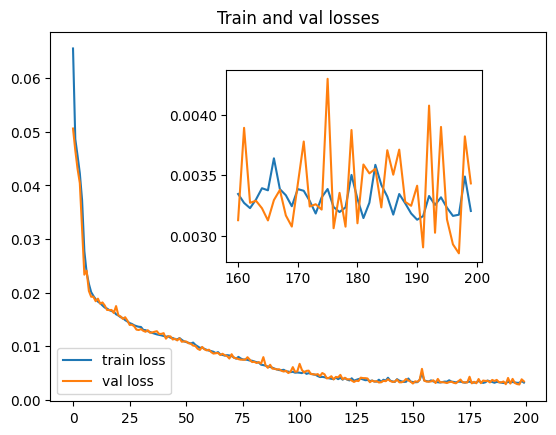

In [11]:
plot, axes = plt.subplots()
axes.plot(history['loss'],label='train loss')
axes.plot(history['val_loss'],label='val loss')
axes_2 = plot.add_axes([0.4,0.4,0.4,0.4])
axes_2.plot(range(int(0.8*len(history['loss'])),len(history['loss'])),history['loss'][int(0.8*len(history['loss'])):],label='train loss')
axes_2.plot(range(int(0.8*len(history['loss'])),len(history['loss'])),history['val_loss'][int(0.8*len(history['loss'])):],label='val loss')
axes.legend(loc='lower left')
axes.set_title('Train and val losses')

Text(0.5, 1.0, 'Train and val Accs')

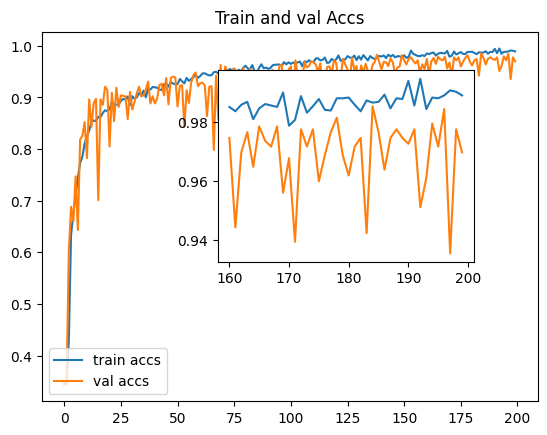

In [12]:
plot, axes = plt.subplots()
axes.plot(history['accs'],label='train accs')
axes.plot(history['val_accs'],label='val accs')
axes_2 = plot.add_axes([0.4,0.4,0.4,0.4])
axes_2.plot(range(int(0.8*len(history['loss'])),len(history['loss'])),history['accs'][int(0.8*len(history['loss'])):],label='train accs')
axes_2.plot(range(int(0.8*len(history['loss'])),len(history['loss'])),history['val_accs'][int(0.8*len(history['loss'])):],label='val accs')
# axes_2.set_xticks([int(0.8*EPOCHS), EPOCHS])
axes.legend(loc='lower left')
axes.set_title('Train and val Accs')

### Loading the best performing model

In [13]:
# Loads the model weights at the lowest validation score

alpha_model.load_state_dict(best_weights)
alpha_delta_model.load_state_dict(best_delta_weights)
print(best_val_loss)

0.002857220073814924


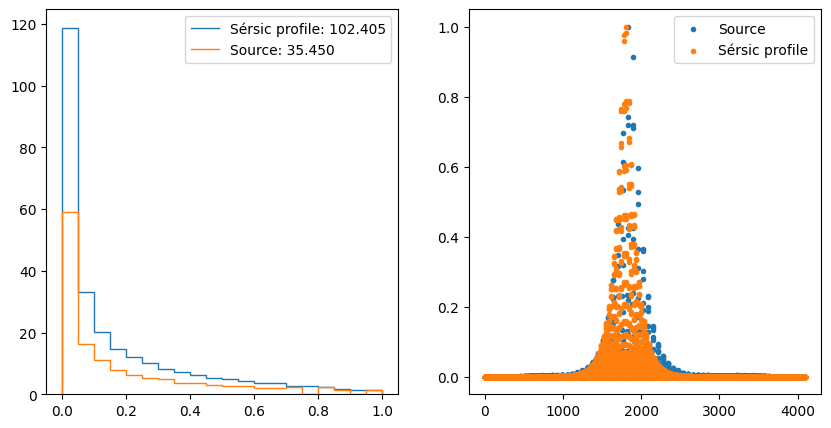

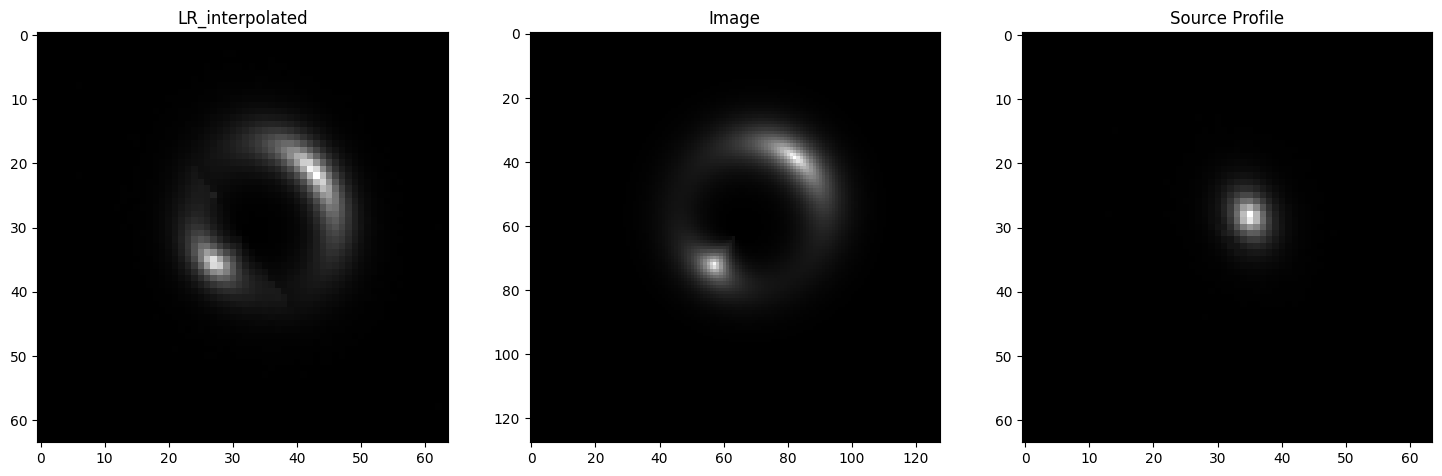

In [14]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

In [15]:
torch.save(best_weights, 'Weights_3.pt')
torch.save(best_delta_weights, 'Delta_3.pt')